<a href="https://colab.research.google.com/github/SShresth7272/Python-Code/blob/main/Logistic_Regression_with_Data_Filtering_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== INITIAL DATA ===
Dataset shape: (1000, 7)
Target distribution:
has_defaulted
0    685
1    315
Name: count, dtype: int64

Missing values:
age                 0
income              0
credit_score        0
loan_amount         0
employment_years    0
debt_to_income      0
has_defaulted       0
dtype: int64

=== DATA FILTERING ===
Data after filtering: (907, 7)
Data after outlier removal: (897, 7)

=== FEATURE ENGINEERING ===
Features after engineering: ['age', 'income', 'credit_score', 'loan_amount', 'employment_years', 'debt_to_income', 'has_defaulted', 'income_to_loan_ratio', 'age_group_Adult', 'age_group_Middle', 'age_group_Senior', 'credit_risk_category_Fair', 'credit_risk_category_Good', 'credit_risk_category_Excellent']

=== DATA PREPARATION ===
Original class distribution: [618 279]
Resampled class distribution: [618 618]
Training set size: (988, 13)
Test set size: (248, 13)

=== MODEL TRAINING ===

=== MODEL EVALUATION ===
Confusion Matrix:
[[99 25]
 [60 64]]

Classification R

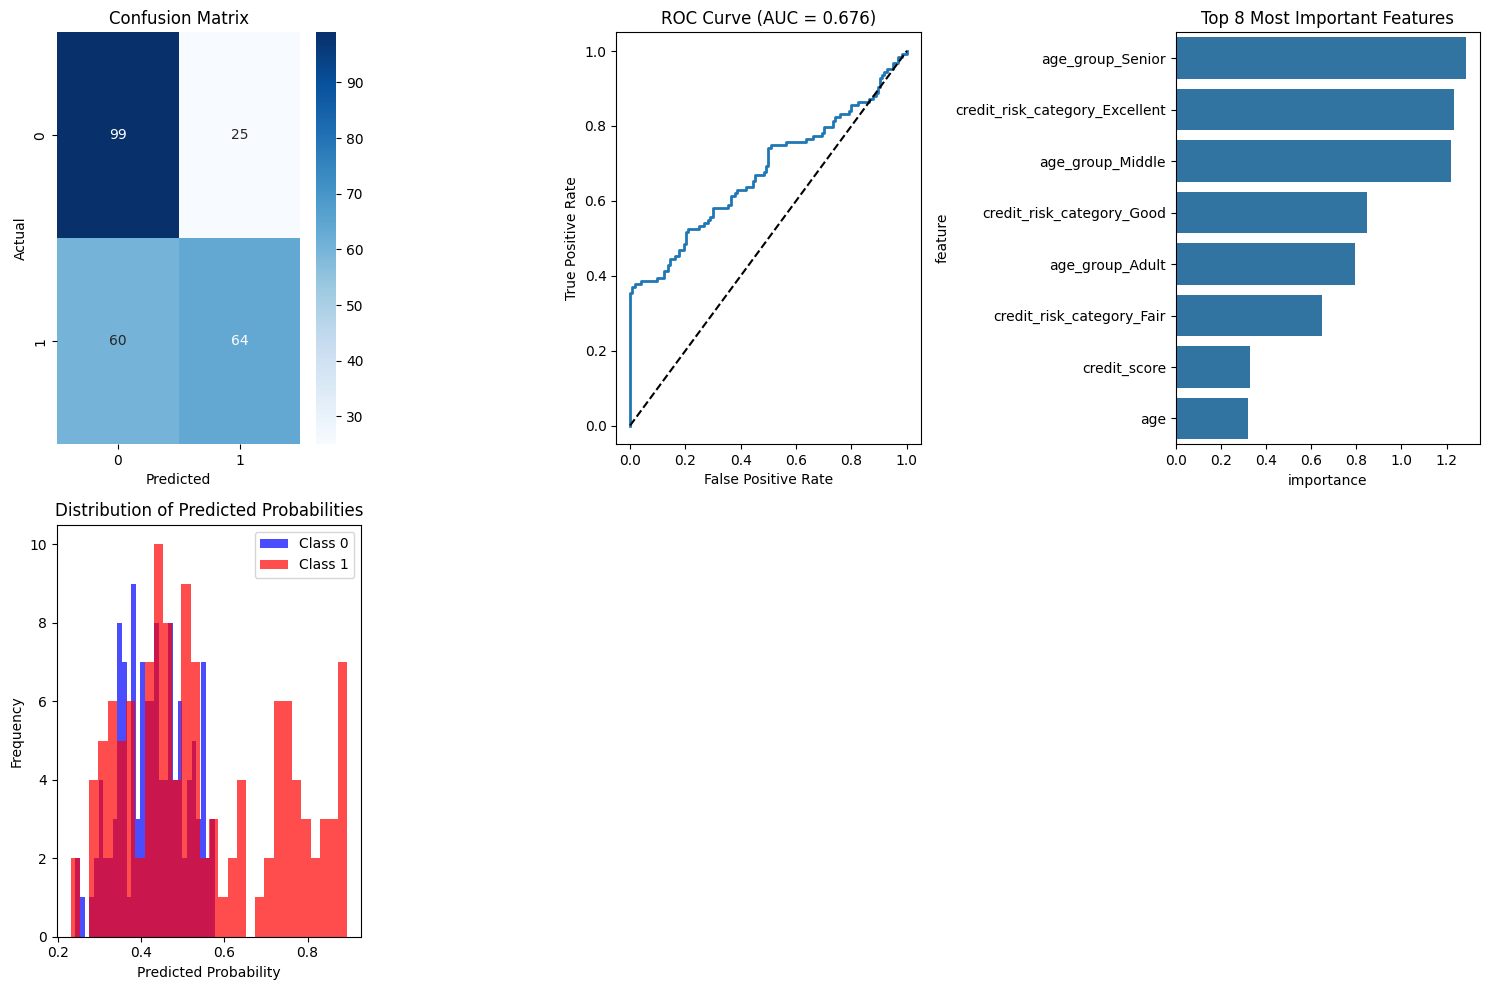


=== EXAMPLE PREDICTION ===
Predicted default probability: 0.3557


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample dataset
np.random.seed(42)
n_samples = 1000

data = {
    'age': np.random.randint(18, 80, n_samples),
    'income': np.random.normal(50000, 20000, n_samples),
    'credit_score': np.random.normal(650, 100, n_samples),
    'loan_amount': np.random.normal(100000, 50000, n_samples),
    'employment_years': np.random.exponential(10, n_samples),
    'debt_to_income': np.random.normal(0.3, 0.15, n_samples),
    'has_defaulted': np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
}

df = pd.DataFrame(data)

# Display initial data info
print("=== INITIAL DATA ===")
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['has_defaulted'].value_counts()}")
print("\nMissing values:")
print(df.isnull().sum())

# DATA FILTERING AND CLEANING
print("\n=== DATA FILTERING ===")

# Filter out unrealistic values
df_filtered = df[
    (df['age'] >= 18) &
    (df['age'] <= 100) &
    (df['income'] > 0) &
    (df['credit_score'] >= 300) &
    (df['credit_score'] <= 850) &
    (df['loan_amount'] > 0) &
    (df['employment_years'] >= 0) &
    (df['debt_to_income'] >= 0) &
    (df['debt_to_income'] <= 1)
].copy()

print(f"Data after filtering: {df_filtered.shape}")

# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in ['income', 'credit_score', 'loan_amount', 'debt_to_income']:
    df_filtered = remove_outliers(df_filtered, column)

print(f"Data after outlier removal: {df_filtered.shape}")

# FEATURE ENGINEERING
print("\n=== FEATURE ENGINEERING ===")

# Create new features
df_filtered['income_to_loan_ratio'] = df_filtered['income'] / df_filtered['loan_amount']
df_filtered['age_group'] = pd.cut(df_filtered['age'],
                                 bins=[0, 30, 45, 60, 100],
                                 labels=['Young', 'Adult', 'Middle', 'Senior'])
df_filtered['credit_risk_category'] = pd.cut(df_filtered['credit_score'],
                                           bins=[0, 580, 670, 740, 850],
                                           labels=['Poor', 'Fair', 'Good', 'Excellent'])

# Convert categorical to dummy variables
df_processed = pd.get_dummies(df_filtered, columns=['age_group', 'credit_risk_category'], drop_first=True)

print(f"Features after engineering: {list(df_processed.columns)}")

# PREPARE DATA FOR MODELING
print("\n=== DATA PREPARATION ===")

# Define features and target
X = df_processed.drop('has_defaulted', axis=1)
y = df_processed['has_defaulted']

# Handle class imbalance using SMOTE (optional)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original class distribution: {np.bincount(y)}")
print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'income', 'credit_score', 'loan_amount', 'employment_years',
                  'debt_to_income', 'income_to_loan_ratio']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# BUILD AND EVALUATE LOGISTIC REGRESSION MODEL
print("\n=== MODEL TRAINING ===")

# Initialize and train model
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle any remaining class imbalance
    C=0.1  # Regularization strength
)

logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# MODEL EVALUATION
print("\n=== MODEL EVALUATION ===")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(logreg.coef_[0])
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

# VISUALIZATIONS
plt.figure(figsize=(15, 10))

# Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(2, 3, 2)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Feature Importance Plot
plt.subplot(2, 3, 3)
sns.barplot(data=feature_importance.head(8), x='importance', y='feature')
plt.title('Top 8 Most Important Features')

# Distribution of Predicted Probabilities
plt.subplot(2, 3, 4)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.tight_layout()
plt.show()

# MODEL DEPLOYMENT READY FUNCTION
def predict_default_probability(new_data, model=logreg, scaler=scaler, feature_names=X.columns):
    """
    Predict default probability for new data

    Parameters:
    new_data: DataFrame with the same features as training data
    model: Trained logistic regression model
    scaler: Fitted StandardScaler
    feature_names: Expected feature names

    Returns:
    probabilities: Array of predicted probabilities for class 1
    """
    # Ensure data has correct features
    new_data = new_data.reindex(columns=feature_names, fill_value=0)

    # Scale numerical features
    numerical_cols = ['age', 'income', 'credit_score', 'loan_amount', 'employment_years',
                      'debt_to_income', 'income_to_loan_ratio']
    new_data[numerical_cols] = scaler.transform(new_data[numerical_cols])

    # Predict probabilities
    probabilities = model.predict_proba(new_data)[:, 1]

    return probabilities

# Example usage with new data
print("\n=== EXAMPLE PREDICTION ===")
sample_new_data = pd.DataFrame([{
    'age': 45,
    'income': 60000,
    'credit_score': 720,
    'loan_amount': 150000,
    'employment_years': 8,
    'debt_to_income': 0.25,
    'income_to_loan_ratio': 60000/150000,
    'age_group_Adult': 1,
    'age_group_Middle': 0,
    'age_group_Senior': 0,
    'credit_risk_category_Fair': 0,
    'credit_risk_category_Good': 1,
    'credit_risk_category_Excellent': 0
}])

# Ensure all expected columns are present
sample_new_data = sample_new_data.reindex(columns=X.columns, fill_value=0)

prediction = predict_default_probability(sample_new_data)
print(f"Predicted default probability: {prediction[0]:.4f}")